# Evolution of actors careers post-blockbuster in the film industry
How does a significant box office success impact an actor's subsequent choices and overall career path ?

##  Context

Analyze career trajectories of actors following their roles in high-grossing films using the CMU Movie Dataset

More specifically, explore the following research questions: 
- Does a high-grossing film consistently lead to **continued box office success** for its actors in their subsequent films?
- Is there a noticeable **change in genre or type of characters** portrayed by actors after a significant hit?
- What are the long-term career impacts on actors who have starred in blockbuster hits?

In [1]:
# External imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1) Loading data:

In [2]:
# Load data
DATA_FOLDER = './MovieSummaries'
CHARACTER_DATASET = DATA_FOLDER + '/character.metadata.tsv'
MOVIE_DATASET = DATA_FOLDER + '/movie.metadata.tsv'
NAME_DATASET = DATA_FOLDER + '/name.clusters.txt'
PLOT_DATASET = DATA_FOLDER + '/plot_summaries.txt'
TVTROPES_DATASET = DATA_FOLDER + '/tvtropes.clusters.txt'

characters_columns = ['wikiID', 'movieID', 'releaseDate', 'charactName', 'birth', 'gender', 'height', 'ethnicity',
                      'name_actor', 'age', 'charActID', 'charID', 'actID']
movies_columns = ['wikiID', 'movieID', 'name_movie', 'releaseDate', 'revenue', 'runtime', 'languages',
                  'countries', 'genres']

characters = pd.read_table(CHARACTER_DATASET, header=None, names=characters_columns)
movies = pd.read_table(MOVIE_DATASET, header=None, names=movies_columns)


In [3]:
# Visualize characters data table
characters.head()

,wikiID,movieID,releaseDate,charactName,birth,gender,height,ethnicity,name_actor,age,charActID,charID,actID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [4]:
# Visualize movies data table
movies.head()

,wikiID,movieID,name_movie,releaseDate,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


## 2) Useful data for our problematics

From this dataset, we first look at the **amount of information** available for each feature. This will help us determine the feasability of our project and guide us for the selection of a relevant subset of data to work on.

With such a large database, it is complex to find a model that both describes the career of an English celebrity in the 40's and that of an actor in Japan in the 2000's. Cultural and economic differences also make it difficult to find a common metric for success. Therefore, we would like to limit ourselves to a consistent and comprehensible subset of the data.

#### Relevant features
First of all, we need to select the features we are interested in in the database. We decided to define the success of an actor depending on the number of movies they played and their corresponding box office revenue. It might also be relevant to have an understanding of the time line for the description of the career of an actor. In addition we would like to have information about the actor such as age, gender and ethnicity to mitigate a possible bias comming from a diffence in population distribution in our analysis. 

Thus the features we want to check are:
* Actor name
* Actor date of birth or age at the time of the movie
* Actor gender
* Actor ethnicity
* Movie box office revenue
* Movie release date

In [5]:
# Make deep copies to make sure not to change original data
characters_copy = characters.copy()
movies_copy = movies.copy()

We want to populate the characters data set with information on the movie in which characters appear. For this we perfom a left merge on characters_copy with movies_copy

In [6]:
# Populate the character dataset with infromations about the movies
character_movies = pd.merge(characters_copy, movies_copy, on=['wikiID', 'movieID', 'releaseDate'] , how='left')

Let's look at the amount of data on movie revenue and movie date that is missing (remember that a movie can appear multiple times - we can have data about two different actors that appeared in the same movie)

In [7]:
# Compute the total number of movies
nb_movies = len(character_movies['movieID'].unique())

# Compute the number of movies for which we have "box office revenue"
character_movies_revenue = character_movies[['movieID', 'revenue']]
character_movies_revenue = character_movies_revenue.dropna()
nb_movies_revenue = len(character_movies_revenue['movieID'].unique())

# Compute the number of movies for which we have "release date"
character_movies_date = character_movies[['movieID', 'releaseDate']]
character_movies_date = character_movies_date.dropna()
nb_movies_date = len(character_movies_date['movieID'].unique())

# Print the results
print(f"The total number of movies we have is: {nb_movies}")
print(f"The percentage of movies for which we have the revenue: {nb_movies_revenue/nb_movies*100 :.2f}%")
print(f"The percentage of movies for which we have the release date: {nb_movies_date/nb_movies*100 :.5f}%")

The total number of movies we have is: 64330
The percentage of movies for which we have the revenue: 12.78%
The percentage of movies for which we have the release date: 94.23753%


As we can see most movies have a release date but only about 13% have information about the box office revenue. Let's look at this percentage per year (with a temporal axis).

In [8]:
from helpers import complete_date

# Make deep copy and keep only the movies for which we have the release date
character_movies_filtered = character_movies.copy()
character_movies_filtered = character_movies_filtered.dropna(subset=['releaseDate'])

# Apply complete_date function to all release dates
character_movies_filtered['releaseDate'] = character_movies_filtered['releaseDate'].apply(complete_date)

# Convert to datetime format
character_movies_filtered['releaseDate'] = pd.to_datetime(character_movies_filtered['releaseDate'], errors='coerce')

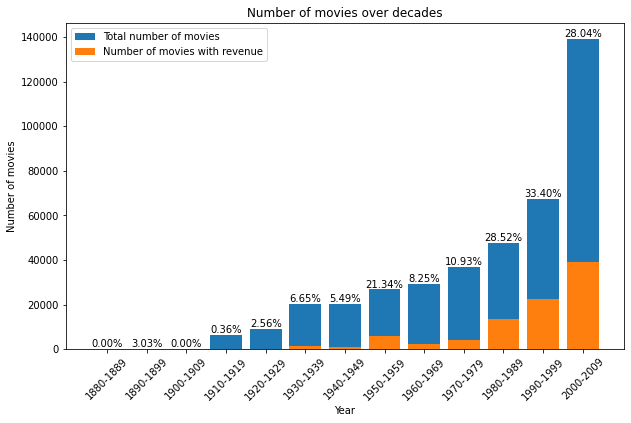

In [9]:
# Add a column with the year of the release date
character_movies_filtered['year'] = character_movies_filtered['releaseDate'].dt.year

# Count the number of movies per 10 years interval
# For the total number of movies
intervals = pd.cut(character_movies_filtered['year'], bins=range(1880, 2016, 10), right=False)
nb_movies_per_interval = intervals.value_counts().sort_index()

# For movies with the revenue
character_movies_filtered_revenue = character_movies_filtered.dropna(subset=['revenue'])
intervals_revenue = pd.cut(character_movies_filtered_revenue['year'], bins=range(1880, 2016, 10), right=False)
nb_movies_per_interval_revenue = intervals_revenue.value_counts().sort_index()

plt.figure(figsize=(10, 6))

# Plot bar plot of number of movies per year
tot_bar=plt.bar([f'{b.left}-{b.right-1}' for b in nb_movies_per_interval.index], 
                nb_movies_per_interval.values, label='Total number of movies')
revenue_bar=plt.bar([f'{b.left}-{b.right-1}' for b in nb_movies_per_interval_revenue.index],
                    nb_movies_per_interval_revenue.values, label='Number of movies with revenue')

plt.title('Number of movies over decades')
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.tick_params(axis='x', rotation=45)
plt.legend()

# Add the percentage on top of each bar
for i, tot_bar in enumerate(tot_bar):
    height_tot_bar = tot_bar.get_height()
    height_revenue_bar = revenue_bar[i].get_height()
    percent = height_revenue_bar/height_tot_bar *100
    plt.text(tot_bar.get_x() + tot_bar.get_width() / 2, height_tot_bar + 5, 
             f'{percent:.2f}%', ha='center', va='bottom')

# Show graph
plt.show()

From this graph we can see that the percentage of revenue data increases through the year. It might thus be more relevant to perform our analysis on a subset of the years for which the revenue information is more present. We could for example only take movies starting from 1950.

In [10]:
# Remove all movies that where released before 1950
character_movies_filtered = character_movies_filtered[character_movies_filtered.year >= 1950]

# Look at the percentage of revenue data in this subset:
# Compute the total number of movies
nb_movies_selec = len(character_movies_filtered['movieID'].unique())

# Compute the number of movies for which we box office revenue
character_movies_filtered_revenue_selec = character_movies_filtered[['movieID', 'revenue']]
character_movies_filtered_revenue_selec = character_movies_filtered_revenue_selec.dropna()
nb_movies_selec_revenue = len(character_movies_filtered_revenue_selec['movieID'].unique())

print(f"The percentage of movies for which we have the revenue after 1950: {nb_movies_selec_revenue/nb_movies_selec*100 :.2f}%")

The percentage of movies for which we have the revenue after 1950: 15.99%


Let's have a look at the amount of revenue data we have per country

In [11]:
from helpers import sort_words, create_words_database
# Make deep copy for the country analysis
df_country = character_movies_filtered.copy()

# Change countries into a list of String
df_country['countries'] = df_country['countries'].str.extract(r'\"([\w\s]+)\"')
df_country['countries'] = df_country['countries'].apply(lambda x: [x] if pd.notna(x) else ['Unknown'])

# Count the number of movies per country
countries_list = df_country['countries'].tolist()
# Flaten the list of countries and sort the resulting list
stored_countries = sort_words(countries_list)
# Count the number of repetition per country
nb_movies_per_country = create_words_database(stored_countries)
# Sort by ascending order of movies made per country
nb_movies_per_country = dict(sorted(nb_movies_per_country.items(), key=lambda item: item[1]))
# Remove countries that shot less than 200 movies
nb_movies_per_country = {country: nb for country, nb in nb_movies_per_country.items() if nb >= 200}


# Count the number of movies with known revenue per country
countries_list = df_country.dropna(subset=['revenue'])['countries'].tolist()
# Flaten the list of countries and sort the resulting list
stored_countries = sort_words(countries_list)
# Count the number of repetition per country
nb_movies_per_country_revenue = create_words_database(stored_countries)
# Sort by ascending order of movies made per country
nb_movies_per_country_revenue = dict(sorted(nb_movies_per_country_revenue.items(), key=lambda item: item[1]))


# Keep countries with more than 200 movies and add to nb_movies_per_country_revenue countries without revenue data (set their number of movies to zero)
country_200_movie = list(nb_movies_per_country.keys())
nb_movies_per_country_revenue = {country: nb for country, nb in nb_movies_per_country_revenue.items() if country in country_200_movie}
nb_movies_per_country_revenue.update({country: 0 for country in country_200_movie if country not in nb_movies_per_country_revenue})
nb_movies_per_country_revenue = {country: nb_movies_per_country_revenue[country] for country in nb_movies_per_country}


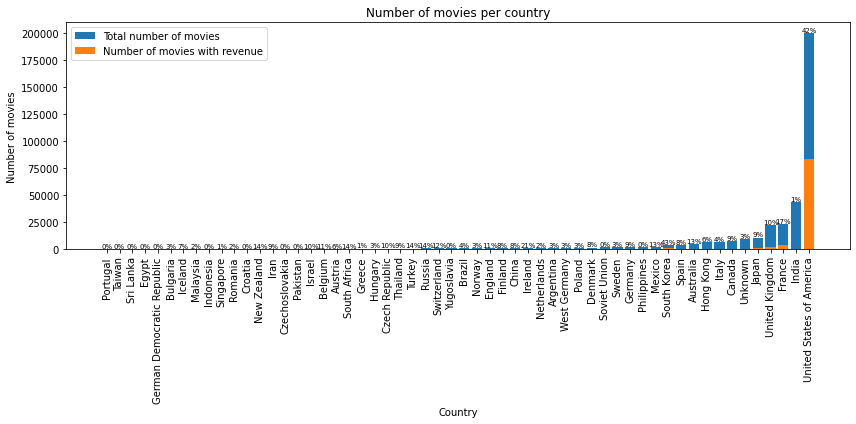

In [12]:
# Extract the names of the countries and the value from each dictionary
country_names = list(nb_movies_per_country.keys())
nb_movies_tot = list(nb_movies_per_country.values())
nb_movies_revenue = list(nb_movies_per_country_revenue.values())

# Make a list of indices for the position of the bars
indices = range(len(country_names))

# Plot histogram
plt.figure(figsize=(12, 6))
bars_tot = plt.bar(indices, nb_movies_tot, label='Total number of movies')
bars_revenue = plt.bar(indices, nb_movies_revenue, label='Number of movies with revenue')

# Add label and title
plt.xlabel('Country')
plt.ylabel('Number of movies')
plt.title('Number of movies per country')
plt.xticks(indices, country_names, rotation=90)

# Add the percentage on top of each bar
for i, bars_tot in enumerate(bars_tot):
    height_bars_tot = bars_tot.get_height()
    height_bars_revenue = bars_revenue[i].get_height()
    percent = height_bars_revenue/height_bars_tot *100
    plt.text(bars_tot.get_x() + bars_tot.get_width() / 2, height_bars_tot + 5,
             f'{percent:.0f}%', ha='center', va='bottom', size=7)


# Show legend and histogram
plt.legend()
plt.tight_layout()
plt.show()


From this plot we can see that the majority of the movies in our dataset come from the U.S. and they also have a high percentage of revenue information. From this we decided to keep only movies that were made in the U.S.

In [13]:
# Keep only movies that where made in the U.S.
character_movies_filtered = character_movies_filtered[
    character_movies_filtered.countries.apply(lambda x:"United States of America" in x)]

# Keep only movies for which we have the revenue
character_movies_filtered = character_movies_filtered.dropna(subset=['revenue'])

# Compute the number of movies left
nb_tot_filtered_movies = len(character_movies_filtered['movieID'].unique())

print(f'The remaining number of movies after the filtration is: {nb_tot_filtered_movies}.')

The remaining number of movies after the filtration is: 6520.


Now that we have filtered our data to have only U.S. movies which where released after and including the year 1950 and that have the revenue data we will look at the data we have on the actors.

In [14]:
# Compute the total number of characters and actors
nb_actors = len(character_movies_filtered['name_actor'].unique())

# Compute the number of actors for which we have the name
character_movies_name = character_movies_filtered[['name_actor']]
character_movies_name = character_movies_name.dropna()
nb_actors_name = len(character_movies_name['name_actor'].unique())

# Compute the number of actors for which we have the date of birth
character_movies_birth = character_movies_filtered[['birth', 'name_actor']]
character_movies_birth = character_movies_birth.dropna()
nb_actors_birth = len(character_movies_birth['name_actor'].unique())

# Computer the number of actors for which we have the age (positive number)
character_movies_age = character_movies_filtered[['age', 'name_actor']]
character_movies_age = character_movies_age.dropna()
character_movies_age = character_movies_age[character_movies_age.age>=0]
nb_actors_age = len(character_movies_age['name_actor'].unique())

# Compute the number of actors for which we have the gender
character_movies_gender = character_movies_filtered[['gender', 'name_actor']]
character_movies_gender = character_movies_gender.dropna()
nb_actors_gender = len(character_movies_gender['name_actor'].unique())


# Compute the number of actors for which we have the ethnicity
character_movies_ethnicity = character_movies_filtered[['ethnicity', 'name_actor']]
character_movies_ethnicity = character_movies_ethnicity.dropna()
nb_actors_ethnicity = len(character_movies_ethnicity['name_actor'].unique())

# Print the results
print(f"The total number of actors we have is: {nb_actors}")
print(f"The percentage of actors for which we have the name is: {nb_actors_name/nb_actors*100 :.5f}")
print(f"The percentage of actors for which we have the birth date is: {nb_actors_birth/nb_actors*100 :.2f}")
print(f"The percentage of actors for which we have the age is: {nb_actors_age/nb_actors*100 :.2f}")
print(f"The percentage of actors for which we have the gender is: {nb_actors_gender/nb_actors*100 :.2f}")
print(f"The percentage of actors for which we have the ethnicity is: {nb_actors_ethnicity/nb_actors*100 :.2f}")

The total number of actors we have is: 29674
The percentage of actors for which we have the name is: 99.99663
The percentage of actors for which we have the birth date is: 63.55
The percentage of actors for which we have the age is: 61.42
The percentage of actors for which we have the gender is: 84.89
The percentage of actors for which we have the ethnicity is: 14.77


From this analysis we can see that we have enough information on the gender and on the age (esp. with birth date) of the actors. However ethnicity data is often missing. Thus, it might be good to filter only for birth date and gender.

In [15]:
# Filter for birth date
character_movies_filtered = character_movies_filtered.dropna(subset=['birth'])

# Filter for gender (NaN and aberrant values)
character_movies_filtered = character_movies_filtered.dropna(subset=['gender'])
character_movies_filtered = character_movies_filtered[
    (character_movies_filtered.gender=='F') | (character_movies_filtered.gender=='M')]

# Compute the remaining number of actors and movies
nb_tot_filtered_movies = len(character_movies_filtered['movieID'].unique())
nb_tot_filtered_actors = len(character_movies_filtered['name_actor'].unique())

print(f'The remaining number of movies is: {nb_tot_filtered_movies}.')
print(f'The remaining number of actors is: {nb_tot_filtered_actors}.')

The remaining number of movies is: 6495.
The remaining number of actors is: 18649.


Now that we have reduced our dataset to this smaller subset we can see that data handling will not be a problem.

We will need to further filter our dataset to keep only actors that played at least in two movies. Let's first look at the distribution of the number of movies played by actor.

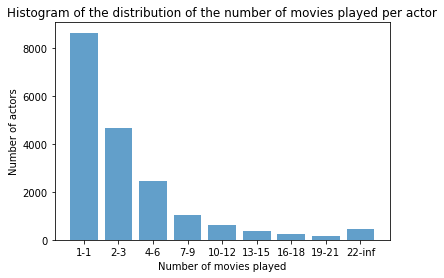

In [16]:
# List all actors name (for filtered data)
actors_names = character_movies_filtered['name_actor'].tolist()

#count the repertition number of each actor name
nb_mov_actor = create_words_database(sorted(actors_names))

# Sort the actors by ascending order of movies played
nb_mov_actor = dict(sorted(nb_mov_actor.items(), key=lambda item: item[1]))

# Define intervals
intervals = [1, 3, 6, 9, 12, 15, 18, 21]

# Initialize a dictionary to stock the number of actors in each interval
actors_per_interval = {i: 0 for i in range(len(intervals) + 1)}

# Count the number of actors in each interval
for actor, index in nb_mov_actor.items():
    for i, threshold in enumerate(intervals):
        if index <= threshold:
            actors_per_interval[i] += 1
            break
    else:
        actors_per_interval[len(intervals)] += 1

# Plot histogram
plt.bar(actors_per_interval.keys(), actors_per_interval.values(), align='center', alpha=0.7)
plt.xticks(list(actors_per_interval.keys()), [f"{i+1}-{j}" for i, j in zip([0] + intervals, intervals + [float('inf')])])
plt.xlabel('Number of movies played')
plt.ylabel("Number of actors")
plt.title('Histogram of the distribution of the number of movies played per actor')
plt.show()

From this histogram we see that many actors played in only one movie so we will further decrease the size of our dataset to only keep actors that played in at least two movies.

In [17]:
from helpers import at_least_2_movies

# Apply filtering function to actor dictionary
filtered_actors = dict(filter(at_least_2_movies, nb_mov_actor.items()))

# Filter dataset
character_movies_filtered = character_movies_filtered[character_movies_filtered['name_actor'].isin(filtered_actors.keys())]

# Compute the remaining number of actors and movies
nb_tot_filtered_movies = len(character_movies_filtered['movieID'].unique())
nb_tot_filtered_actors = len(character_movies_filtered['name_actor'].unique())

print(f'The remaining number of movies is: {nb_tot_filtered_movies}.')
print(f'The remaining number of actors is: {nb_tot_filtered_actors}.')

The remaining number of movies is: 6443.
The remaining number of actors is: 10008.


## 3) What is a big hit? :
We now have to define what makes a movie a big hit? We will focus on revenue as mentioned eariler but we still have to find define how much revenue leads to calling a movie a big hit.

For this, let's look at the distribution of revenue amoung our filtered movie dataset (movies that have revenue information, that come from the US and that were made after 1950). Because of inflation I will probably be required to perform some kind of normalization over the years to make sure we do not have a year bias.

Let's thus look at the average revenue of movies over the years

[]

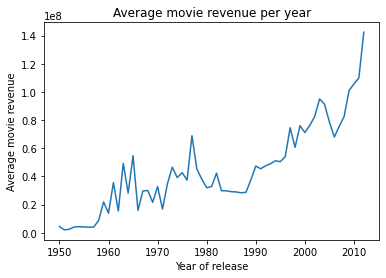

In [18]:
# Get the mean and standard deviation of the box office revenue for each year
unique_movies = character_movies_filtered.drop_duplicates(subset = 'movieID')
rev_per_year = unique_movies.groupby(by = 'year')['revenue']
avg_revenue_per_year = rev_per_year.mean()
std_revenue_per_year = rev_per_year.std()

# Plot the results
plt.plot(avg_revenue_per_year)
#plt.fill_between(avg_revenue_per_year.index, (avg_revenue_per_year+std_revenue_per_year).values,
#                 (avg_revenue_per_year-std_revenue_per_year).values, color='lightblue')
plt.title('Average movie revenue per year')
plt.ylabel('Average movie revenue')
plt.xlabel('Year of release')
plt.plot()

From this graph we can see a certain fluctuation in the average movie revenue per year.

To keep things simple we will assume that for a movie to be a big hit it has to be an outliner with respect to box office revenue. We will pick only the outlines (for box office revenue) each year as label them as big hits. We define an outliner as: outlier's revenue > Q3 + 1.5*(IQR) where Q1, Q3 and IQR are respectively the first quantile, the third quantile and the interquantile range.

The number of big hits is: 677


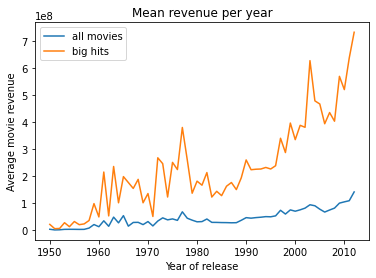

In [19]:
# Compute the first and the third quantile for each year
Q1 = rev_per_year.quantile(q=0.25)
Q3 = rev_per_year.quantile(q=0.75)

# Compute our ouliner threshold value for each year
outliner_thresh = Q3 + 1.5 *(Q3-Q1)
outliner_thresh.name = 'threshold'

# Filter movie dataset to keep only the big hits
movies_merged = pd.merge(character_movies_filtered, outliner_thresh, left_on='year', right_index=True)
big_hits = movies_merged[movies_merged['revenue'] > movies_merged['threshold']]

# Plot the mean revenue for big hits compaired to the mean revenue for all movies per year
unique_movie_hits = big_hits.drop_duplicates(subset = 'movieID')
rev_hits_per_year = unique_movie_hits.groupby(by = 'year')['revenue'].mean()

plt.plot(avg_revenue_per_year, label = 'all movies')
plt.plot(rev_hits_per_year, label = 'big hits')

# Add labels
plt.title('Mean revenue per year')
plt.ylabel('Average movie revenue')
plt.xlabel('Year of release')
plt.legend()
plt.plot()

# How many big hits do we have?
print(f'The number of big hits is: {len(unique_movie_hits)}')

Do we have enough data? If not: change the ouliner definition or change big hit definition

Now let's divide our actors dataset into the ones that have played in one of those big hits (treatement group) and the ones that did not (control)

In [20]:
# Get a set with the names of the actors that played in a big hit
unique_actor_hits = big_hits.drop_duplicates(subset = 'name_actor').name_actor

# Creat a new column on our main dataframe, a bool for wheter the actors played in a big hit or not
character_movies_filtered['big_hit_actor'] = character_movies_filtered.name_actor.isin(unique_actor_hits)

# Get a dataframe of actors that played in a big hit (treatement group)
actors_big_hit = character_movies_filtered[character_movies_filtered.big_hit_actor]
# Get a dataframe of actors that did not play in a big hit (control group)
actors_no_big_hit = character_movies_filtered[~character_movies_filtered.big_hit_actor]

# Print the number of actors in each group
nb_big_hit_actors = len(unique_actor_hits)

print(f'The number of actors that played in a big hit is: {nb_big_hit_actors} (treatement group)')
print(f'The number of actors that did not play in a big hit is: {nb_tot_filtered_actors-nb_big_hit_actors} (control group)')

The number of actors that played in a big hit is: 4477 (treatement group)
The number of actors that did not play in a big hit is: 5531 (control group)


Now that we have our two groups let's look at the distribution of different variables for which we have information.

We can first look at gender.

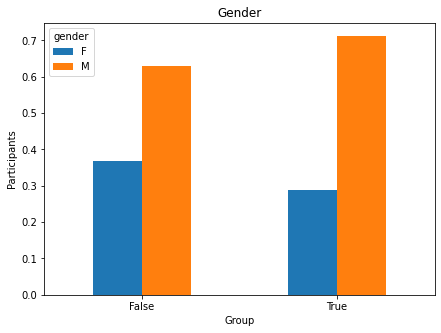

In [31]:
# Gender
group = character_movies_filtered.groupby(['big_hit_actor', 'gender'])['gender'].count()
group = group.unstack()
group = group.div(group.sum(axis=1), axis=0)

pl = group.plot(kind='bar', figsize=[7,5], rot=0)
pl.set_title('Gender')
pl.set_ylabel('Participants')
pl.set_xlabel('Group')
plt.show()

Now let's have look at the repartition of the age at the peak of the acotrs carrier (good?). We define the peak of one actor's carrier by the year where the product of the number of movies played in with their respective box office revenue is the highest.


REMARQUE: si on veut etre encore plus precis, on peut ici reprendre le dataset avant d'avoir filter les films sur la presence de revenue. Comme ca on compte aussi ces films la et pour notre calcul on pourrait p.ex. choisir la valeur moyenne de revenue pour l'annee du films (pour lequel il manque le revenue justement).

In [22]:
# TODO: do this earlier?
# Get the birthdate of the actors in the correct format
character_movies_filtered['birth'] = character_movies_filtered['birth'].apply(complete_date)
character_movies_filtered['birth'] = pd.to_datetime(character_movies_filtered['birth'], format='%Y-%m-%d')

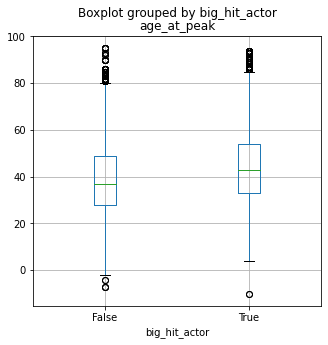

In [23]:
# Calculate the product of the number of movies and respective box office revenue for each actor and year
character_movies_filtered['product'] = character_movies_filtered.groupby(['name_actor', 'year']).movieID.transform('count') * character_movies_filtered.revenue

# Find the row with the maximum product for each actor
max_product_rows = character_movies_filtered.loc[character_movies_filtered.groupby('name_actor')['product'].idxmax()]

# Extract the actor and the corresponding year for the maximum product
result = max_product_rows.loc[:, ['name_actor', 'year', 'birth']]

# Create a column in the dataframe with the age of the actors at their carrier peak:
result['age_at_peak'] = result['year'] - result['birth'].dt.year
character_movies_filtered = pd.merge(character_movies_filtered, result[['name_actor', 'age_at_peak']], on='name_actor', how='left')


# Remove the product column
character_movies_filtered = character_movies_filtered.drop(columns = 'product')

# Visualize distribution

character_movies_filtered.boxplot(by='big_hit_actor', column='age_at_peak', figsize = [5, 5], grid=True)
plt.show()

The two groups are actually pretty much balanced on the two variables we looked at. We should probably still perform a matching (exact matching might take too long? propensity score matching good enough? look at other variable distributions?)

Now, we want to compare the carrer longevity

In [38]:
# Convert releaseDate to DateTime
character_movies_filtered['releaseDate'] = pd.to_datetime(character_movies_filtered['releaseDate'], errors='coerce')

# Drop eventual Nan Values for releaseDate
character_movies_filtered.dropna(subset=['releaseDate'], inplace=True)

# Calculate Last and First Apparence
career_start = character_movies_filtered.groupby('name_actor')['releaseDate'].min()
career_end = character_movies_filtered.groupby('name_actor')['releaseDate'].max()

career_duration = (career_end - career_start).dt.days / 365.25  # Convert days to years
career_duration_df = career_duration.reset_index()
career_duration_df.rename(columns={'releaseDate': 'career_length_in_years'}, inplace=True)


In [40]:
#TODO: give better name to this variable
merged_df = pd.merge(character_movies_filtered, career_duration_df, on='name_actor')


In [45]:
# Analysis
treatment_group = merged_df[merged_df['big_hit_actor'] == True]
control_group = merged_df[merged_df['big_hit_actor'] == False]

mean_career_length_treatment = treatment_group['career_length_in_years'].mean()
mean_career_length_control = control_group['career_length_in_years'].mean()

print(f'The mean carrer longevity of actors that played in a big hit is: {mean_career_length_treatment} (treatement group)')
print(f'The mean carrer longevity of actors that did not play in a big hit is: {mean_career_length_control} (control group)')


The mean carrer longevity of actors that played in a big hit is: 21.800166192944015 (treatement group)
The mean carrer longevity of actors that did not play in a big hit is: 13.374571377354878 (control group)


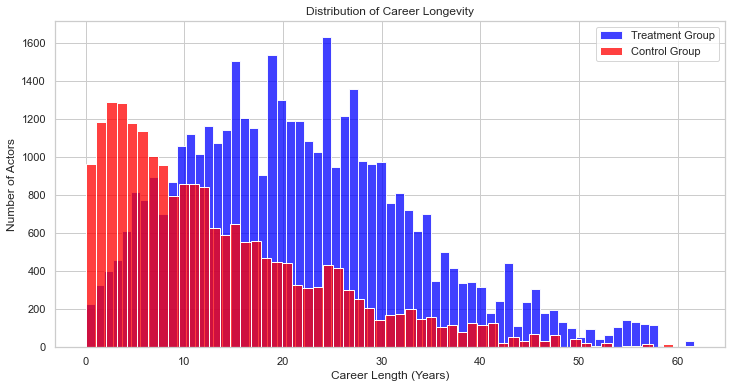

In [48]:
# Histogram

# Set the style
sns.set(style="whitegrid")

# Plot histograms
plt.figure(figsize=(12, 6))
sns.histplot(treatment_group['career_length_in_years'], color="blue", label='Treatment Group')
sns.histplot(control_group['career_length_in_years'], color="red", label='Control Group')

plt.title('Distribution of Career Longevity')
plt.xlabel('Career Length (Years)')
plt.ylabel('Number of Actors')
plt.legend()
plt.show()

The control group appears to have more actors in the shorter career span categories (less than 10 years), whereas the treatment group has a more evenly distributed frequency across different career lengths. The treatment group has more actors with longer careers, indicated by the bars extending further to the right (beyond 30 years), compared to the control group. This suggests that actors who have been in a big hit may have longer-lasting careers.

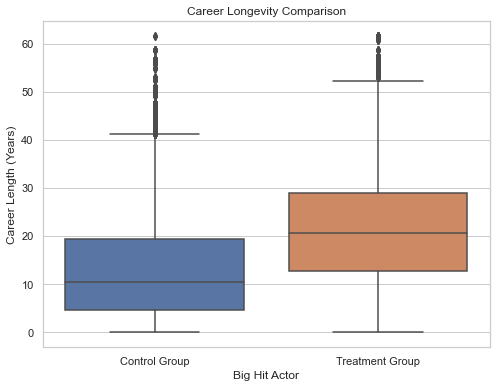

In [49]:
# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='big_hit_actor', y='career_length_in_years', data=merged_df)
plt.title('Career Longevity Comparison')
plt.xlabel('Big Hit Actor')
plt.ylabel('Career Length (Years)')
plt.xticks([0, 1], ['Control Group', 'Treatment Group'])
plt.show()

Comparing the two boxes, we can see that not only is the median of the treatment group higher (indicating longer average career lengths), but the box and whiskers are also generally higher on the scale. This implies that actors in the treatment group not only have a tendency towards longer careers on average but also include more actors with very long careers.

Next, we will look to the number of unique movieIDs associated with each actor to see if actors in big hits tend to appear in more movies overall

## 4) Relating movie genres and actor's careers :

In order to observe the career of actors in movie production, we thought it would be interessant to look at the genres of the movies they were playing in. 

In [24]:
# Get the number of rows
num_rows = character_movies_filtered.shape[0]

# Print the number of rows
print(f"The DataFrame has {num_rows} rows.")

The DataFrame has 63120 rows.


In [25]:
from helpers import extract_genre_names

# Apply the function to the "genres" column
character_movies_filtered['genres'] = character_movies_filtered['genres'].apply(extract_genre_names)

character_movies_filtered.head(5)

,wikiID,movieID,releaseDate,charactName,birth,gender,height,ethnicity,name_actor,age,...,actID,name_movie,revenue,runtime,languages,countries,genres,year,big_hit_actor,age_at_peak
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,/m/03wcfv7,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Thriller, Science Fiction, Horror, Adventure,...",2001.0,False,32.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,/m/0346l4,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Thriller, Science Fiction, Horror, Adventure,...",2001.0,False,21.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,...,/m/01vw26l,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Thriller, Science Fiction, Horror, Adventure,...",2001.0,False,33.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,/m/034hyc,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Thriller, Science Fiction, Horror, Adventure,...",2001.0,False,44.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,...,/m/01y9xg,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Thriller, Science Fiction, Horror, Adventure,...",2001.0,False,22.0


In [26]:
# Group all the genres of movies to see how many remain and which genres exist
movie_genres = character_movies_filtered['genres'].tolist()
all_genres = sorted(list(set([genre for liste_genres in movie_genres for genre in liste_genres])))

In [27]:
print(f"In the remaining dataset we have {len(all_genres)} movie genres as we can see in the following list : ")

for genre in all_genres :
    print(f" ## {genre}")

In the remaining dataset we have 295 movie genres as we can see in the following list : 
 ## Absurdism
 ## Acid western
 ## Action
 ## Action Comedy
 ## Action Thrillers
 ## Action/Adventure
 ## Addiction Drama
 ## Adult
 ## Adventure
 ## Adventure Comedy
 ## Airplanes and airports
 ## Albino bias
 ## Alien Film
 ## Alien invasion
 ## Americana
 ## Animal Picture
 ## Animals
 ## Animated Musical
 ## Animated cartoon
 ## Animation
 ## Anime
 ## Anthology
 ## Anti-war
 ## Anti-war film
 ## Apocalyptic and post-apocalyptic fiction
 ## Archaeology
 ## Archives and records
 ## Art film
 ## Auto racing
 ## Avant-garde
 ## B-Western
 ## B-movie
 ## Backstage Musical
 ## Baseball
 ## Beach Film
 ## Biker Film
 ## Biographical film
 ## Biography
 ## Biopic [feature]
 ## Black comedy
 ## Black-and-white
 ## Blaxploitation
 ## Bloopers & Candid Camera
 ## Bollywood
 ## Boxing
 ## Breakdance
 ## British Empire Film
 ## British New Wave
 ## Buddy cop
 ## Buddy film
 ## Business
 ## Camp
 ## Caper s

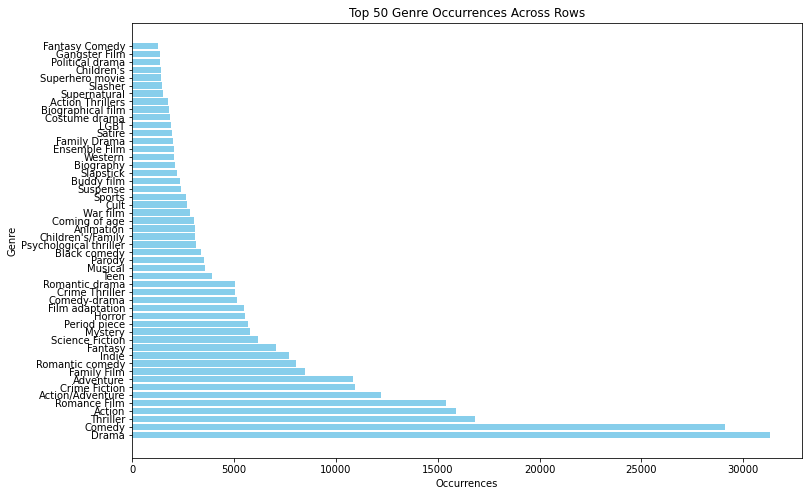

In [28]:
# Create an empty dictionary to track genre occurrences
genre_occurrences = {}

# Iterate through each row
for i, row in character_movies_filtered.iterrows():
    current_genres = row['genres']
    
    # Update the occurrences for each genre
    for genre in current_genres:
        genre_occurrences[genre] = genre_occurrences.get(genre, 0) + 1

# Convert the dictionary to a DataFrame
genre_occurrences_df = pd.DataFrame(list(genre_occurrences.items()), columns=['Genre', 'Occurrence'])

# Sort the DataFrame by occurrence
genre_occurrences_df = genre_occurrences_df.sort_values(by='Occurrence', ascending=False)

# Select the top 50 genres
top_50_genres = genre_occurrences_df.head(50)

# Plot the occurrences of each genre
plt.figure(figsize=(12, 8))
plt.barh(top_50_genres['Genre'], top_50_genres['Occurrence'], color='skyblue')
plt.xlabel('Occurrences')
plt.ylabel('Genre')
plt.title('Top 50 Genre Occurrences Across Rows')
plt.show()


In [29]:
# Print the top 8 genres with the most occurrences
top_8_genres = genre_occurrences_df.head(8)
print("Top 8 genres with the most occurrences:")
print(top_8_genres)


Top 8 genres with the most occurrences:
               Genre  Occurrence
11             Drama       31299
12            Comedy       29101
0           Thriller       16826
5             Action       15908
14      Romance Film       15398
21  Action/Adventure       12231
19     Crime Fiction       10956
3          Adventure       10864


As we just saw before the most represented genres in blockbuster movies are : Drama, Comedy, Thriller, Action, Romance Film, Action/Adventure, Crime Fiction and Adventure. So we can suppose that successful actors act more in movies of those genres.

Analyzing an actor's career becomes particularly insightful when examining their involvement in similar types of movies. The key determinant of similarity among movies lies in their respective genres.

Given the extensive number of movies within our dataset, it becomes prudent to gauge the similarity of each film in which an actor has participated. Consequently, for every actor, we can establish pairwise similarities among the films they've been a part of. A higher similarity value indicates a greater resemblance between two movies. For further informations regarding charachter types, we will analyse plot summaries to extract additional informations on types. This approach allows us to discern whether an actor consistently gravitates towards a specific genre or demonstrates versatility by engaging in various genres.